In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.option_context('display.max_rows', None)
pd.set_option('display.width', 1000)
columns = ['Pressure','Concentration H2','Concentration H', 'Mass density rho', 'Entropy S', 'Internal Energy U',
           'log(drho)/log(T)','log(drho)/log(P)','log(dS)/log(T)', 'log(dS)/log(P)', 'log(dT)/log(P) adiabatic gradient']


df = pd.read_csv('h_tab_i.dat', sep='\s+', skiprows=1, names=columns)
header = pd.DataFrame([[2.10, 30]], columns = ['Pressure', 'Concentration H2'])
eos_table = header.append(df, ignore_index=True, sort=False)
#all logarithms are base10

#Removing columns
drop_col = ['Entropy S','log(drho)/log(T)','log(drho)/log(P)','log(dS)/log(T)', 'log(dS)/log(P)', 'log(dT)/log(P) adiabatic gradient']
eos_table = eos_table.drop(drop_col, axis = 1)
#Output
print(eos_table.head()) #First 5 rows of imported table

   Pressure  Concentration H2  Concentration H  Mass density rho  Internal Energy U
0       2.1              30.0              NaN               NaN                NaN
1       4.0               1.0              0.0           -5.7154            10.1201
2       4.2               1.0              0.0           -5.5154            10.1201
3       4.4               1.0              0.0           -5.3154            10.1201
4       4.6               1.0              0.0           -5.1154            10.1201


In [2]:
#Creating 2 tables
eos_electrons = eos_table.copy()
eos_ions = eos_table.copy()

In [3]:
#Constants
R = 8.3145 #Ideal gas constant (SI units)
cv = 1.5 # 3/2 - monoatomic gas
Na = 6.022e23 #Avogadro number
mass_proton = 1.67e-27 #kg
mass_hydrogen_molecular =  2 * mass_proton #kg

#Conversion coeff:
SI_to_dyn_cm2 = 10 # 1 Pa = 10 dyn/cm^2
SI_to_erg_g = 10000 # 1 J/kg = 10^4 erg/g
g_cm3_to_kg_m3 = 1e3 # 1 g/cm3 = 1000 kg/m3

#Filling electron table
temp_list = []
for index, row in eos_electrons.iterrows():
    #If concentration value in a row is NaN => value stored in pressure column in this row is temperature
    if pd.isnull(row['Concentration H']):
        temperature = row['Pressure']
    temp_list.append(temperature)
eos_electrons['Temperature'] = temp_list #Create a temperature column
eos_ions['Temperature'] = temp_list


In [4]:
print(eos_electrons['Temperature'].head(), '\n', eos_electrons['Temperature'].tail())

0    2.1
1    2.1
2    2.1
3    2.1
4    2.1
Name: Temperature, dtype: float64 
 3778    7.06
3779    7.06
3780    7.06
3781    7.06
3782    7.06
Name: Temperature, dtype: float64


In [5]:
eos_electrons['Concentration e'] = 1 - eos_electrons['Concentration H2'] - eos_electrons['Concentration H'] #electron number concentration
eos_electrons['m total'] = (eos_electrons['Concentration H2'] * mass_hydrogen_molecular + 
                            eos_electrons['Concentration H'] * mass_proton + 
                            eos_electrons['Concentration e'] * mass_proton)
eos_electrons['nu over m coefficient'] = eos_electrons['Concentration e'] / (Na * eos_electrons['m total'])
                                          
eos_electrons['Internal Energy U'] = (SI_to_erg_g * cv * R * (10 ** eos_electrons['Temperature']) * 
                                       eos_electrons['nu over m coefficient']) #erg/g
eos_electrons['Pressure'] = (SI_to_dyn_cm2 * g_cm3_to_kg_m3 * (10 ** eos_electrons['Mass density rho']) * R * 
                             (10 ** eos_electrons['Temperature']) * eos_electrons['nu over m coefficient']) #dyn/cm2

for index, row in eos_electrons.iterrows(): #remove the cases when concentration is negative
    if row['Concentration e'] <= 0: 
        row['Internal Energy U'] = 0
        row['Pressure'] = 0
    else: #convert to log10(erg/g) and log10(dyn/cm^2) for the non-zero cases
        row['Internal Energy U'] = np.log10(row['Internal Energy U']) 
        row['Pressure'] = np.log10(row['Pressure'])

#Filling ions table
eos_ions['Pressure'] = eos_ions['Pressure'] - eos_electrons['Pressure']
eos_ions['Internal Energy U'] = eos_ions['Internal Energy U'] - eos_electrons['Internal Energy U']

#Delete columns
eos_electrons = eos_electrons.drop(columns = ['Concentration e', 'nu over m coefficient', 'm total'])

In [6]:
print(eos_electrons)

       Pressure  Concentration H2  Concentration H  Mass density rho  Internal Energy U  Temperature
0           NaN              30.0              NaN               NaN                NaN         2.10
1      0.000000               1.0         0.000000           -5.7154           0.000000         2.10
2      0.000000               1.0         0.000000           -5.5154           0.000000         2.10
3      0.000000               1.0         0.000000           -5.3154           0.000000         2.10
4      0.000000               1.0         0.000000           -5.1154           0.000000         2.10
5      0.000000               1.0         0.000000           -4.9154           0.000000         2.10
6      0.000000               1.0         0.000000           -4.7154           0.000000         2.10
7      0.000000               1.0         0.000000           -4.5154           0.000000         2.10
8      0.000000               1.0         0.000000           -4.3154           0.000000    

In [7]:
print(eos_ions)

      Pressure  Concentration H2  Concentration H  Mass density rho  Internal Energy U  Temperature
0          NaN              30.0              NaN               NaN                NaN         2.10
1     4.000000               1.0         0.000000           -5.7154          10.120100         2.10
2     4.200000               1.0         0.000000           -5.5154          10.120100         2.10
3     4.400000               1.0         0.000000           -5.3154          10.120100         2.10
4     4.600000               1.0         0.000000           -5.1154          10.120100         2.10
5     4.800000               1.0         0.000000           -4.9154          10.120100         2.10
6     5.000000               1.0         0.000000           -4.7154          10.120000         2.10
7     5.200000               1.0         0.000000           -4.5154          10.120000         2.10
8     5.400000               1.0         0.000000           -4.3154          10.120000         2.10


In [8]:
#Identifying range for density and internal energy

#Constants & conversion coefficients
convert_eV_to_K = 11604.5 # Kelvin
kb = 1.38e-23 #Boltzman constant (SI units)

#Density range
n_min = 1e16 #cm^-3
n_max = 1e20 #cm^-3
n_min_SI = n_min * 1e6 # m^-3
n_max_SI = n_max * 1e6 # m^-3

#rho = (Np * mp + Ne * me)/V => rho_min = (n_min * mp + n_min * me)
rho_electrons_min = mass_proton * n_min * 1e3 #g/cm3 (kg -> g gives a factor of 1e3)
rho_ions_min = rho_electrons_min

#rho_max (n_max * mp + n_max * me)
rho_electrons_max = mass_proton * n_max * 1e3 #g/cm3
rho_ions_max = rho_electrons_max

print('Min density log10(g/cm^3):', np.log10(rho_ions_min))
print('Max density log10(g/cm^3):', np.log10(rho_ions_max))


Min density log10(g/cm^3): -7.777283528852417
Max density log10(g/cm^3): -3.7772835288524167


In [9]:
#Internal energy range
#Min and max temperatures
t_ions_min = 100 #K
t_ions_max = 100 * convert_eV_to_K #K
t_elec_min = 0.0 #K
t_elec_max = t_ions_max
#Calculating min and max internal energies 
# u/m = cv*R*T * nu/m = cv*R*T * (Ni/Na) / (mp * Ni) => cv*R*T / (Na * mp)
# u_ions_min_SI = cv * R * t_ions_min / (mass_proton * Na) # Joule/kg
# u_ions_max_SI = cv * R * t_ions_max / (mass_proton * Na) # Joule/kg
# u_elec_min_SI = 0. #Joule/kg
# u_elec_max_SI = cv * R * t_elec_max / (mass_proton * Na) 

# u_ions_min_erg_g = 1e4 * u_ions_min_SI # erg/g
# u_ions_max_erg_g = 1e4 * u_ions_max_SI
# u_elec_min_erg_g = 1e4 * u_elec_min_SI
# u_elec_max_erg_g = 1e4 * u_elec_max_SI

# u_ions_min_mbar = 1e-8 * u_ions_min_SI # Mbar * cm^3 / g
# u_ions_max_mbar = 1e-8 * u_ions_max_SI
# u_elec_min_mbar = 1e-8 * u_elec_min_SI
# u_elec_max_mbar = 1e-8 * u_elec_max_SI
print('Max temperature of electrons/ions in log10(K):', np.log10(t_elec_max))
#print('Ion internal energy range log10(erg/g):', np.log10(u_ions_min_erg_g), np.log10(u_ions_max_erg_g))
#print('Electron internal energy range log10(erg/g):', u_elec_min_erg_g, np.log10(u_elec_max_erg_g))

Max temperature of electrons/ions in log10(K): 6.064626432864408


In [10]:
#Creating set of densities in range(rho_min, rho_max) 
#NR
numb_densities = 100
step_den = (rho_ions_max - rho_ions_min) / numb_densities
tabulated_densities = np.linspace(np.log10(rho_ions_min), np.log10(rho_ions_max), num = numb_densities) #

#Creating set of temperatures(internal energies) in range
#NE
numb_temperatures = 100
tabulated_temperatures_e = np.linspace(t_elec_min, np.log10(t_elec_max), num = numb_temperatures) 
tabulated_temperatures_i = np.linspace(np.log10(t_ions_min), np.log10(t_ions_max), num = numb_temperatures)
# step_i = (u_ions_max_SI - u_ions_min_SI) / numb_energies
# step_e = (u_elec_max_SI - u_elec_min_SI) / numb_energies

# tabulated_energies_e = np.linspace(u_elec_min_erg_g, np.log10(u_elec_max_erg_g), num = numb_energies) #Joule/kg
# tabulated_energies_i = np.linspace(np.log10(u_ions_min_erg_g), np.log10(u_ions_max_erg_g), num = numb_energies) #Joule/kg

#Storing NR & NE
NR = len(tabulated_densities)
NE_e = len(tabulated_temperatures_e)
NE_i = len(tabulated_temperatures_i)
#Output
print('Density log10(g/cm^3) \n', tabulated_densities, '\n', 'NR = ', NR, '\n')
print('Electron Temperature log10(K) \n', tabulated_temperatures_e, '\n', 'NE_electrons = ', NE_e, '\n')
print('Ion Temperature log10(K) \n', tabulated_temperatures_i, '\n', 'NE_ions =', NE_i, '\n')

Density log10(g/cm^3) 
 [-7.77728353 -7.73687949 -7.69647545 -7.65607141 -7.61566737 -7.57526333
 -7.53485929 -7.49445525 -7.45405121 -7.41364717 -7.37324312 -7.33283908
 -7.29243504 -7.252031   -7.21162696 -7.17122292 -7.13081888 -7.09041484
 -7.0500108  -7.00960676 -6.96920272 -6.92879868 -6.88839464 -6.8479906
 -6.80758656 -6.76718252 -6.72677848 -6.68637444 -6.6459704  -6.60556636
 -6.56516232 -6.52475828 -6.48435424 -6.4439502  -6.40354616 -6.36314211
 -6.32273807 -6.28233403 -6.24192999 -6.20152595 -6.16112191 -6.12071787
 -6.08031383 -6.03990979 -5.99950575 -5.95910171 -5.91869767 -5.87829363
 -5.83788959 -5.79748555 -5.75708151 -5.71667747 -5.67627343 -5.63586939
 -5.59546535 -5.55506131 -5.51465727 -5.47425323 -5.43384919 -5.39344515
 -5.3530411  -5.31263706 -5.27223302 -5.23182898 -5.19142494 -5.1510209
 -5.11061686 -5.07021282 -5.02980878 -4.98940474 -4.9490007  -4.90859666
 -4.86819262 -4.82778858 -4.78738454 -4.7469805  -4.70657646 -4.66617242
 -4.62576838 -4.58536434 -4.5

In [11]:
from scipy import interpolate

#Interpolation for density T-rho table (electrons)
eos_electrons.dropna(inplace = True) #drop NaN values for interpolation
print(eos_electrons['Temperature'].unique()) 
print(len(eos_electrons['Temperature'].unique()))
sub_table_interp = pd.DataFrame()
eos_electrons_interp_rho = pd.DataFrame()
interpolation_columns = ['Pressure', 'Internal Energy U', 'Concentration H2', 'Concentration H']
for temperature in eos_electrons['Temperature'].unique(): #iterate over all temperature values
    sub_table = eos_electrons[eos_electrons['Temperature'] == temperature] #select sub-table at a given temperature
    for column_name in interpolation_columns:
        y = sub_table[column_name]
        x = sub_table['Mass density rho']
        func = interpolate.interp1d(x,y, kind='cubic', bounds_error=False, fill_value='extrapolate') #third order spline interpolation
        xnew = tabulated_densities
        sub_table_interp['Temperature'] = temperature
        sub_table_interp['Density'] = tabulated_densities
        sub_table_interp[column_name] = func(xnew)
    eos_electrons_interp_rho = pd.concat([eos_electrons_interp_rho, sub_table_interp])

        


[2.1  2.18 2.26 2.34 2.42 2.5  2.58 2.66 2.74 2.82 2.9  2.98 3.06 3.14
 3.22 3.3  3.38 3.46 3.54 3.62 3.7  3.78 3.86 3.94 4.02 4.1  4.18 4.26
 4.34 4.42 4.5  4.58 4.66 4.74 4.82 4.9  4.98 5.06 5.14 5.22 5.3  5.38
 5.46 5.54 5.62 5.7  5.78 5.86 5.94 6.02 6.1  6.18 6.26 6.34 6.42 6.5
 6.58 6.66 6.74 6.82 6.9  6.98 7.06]
63


In [12]:
print(eos_electrons_interp_rho)
eos_electrons_interp_rho.reset_index(inplace=True)

    Temperature   Density   Pressure  Internal Energy U  Concentration H2  Concentration H
0          2.10 -7.777284   0.000000           0.000000               1.0         0.000000
1          2.10 -7.736879   0.000000           0.000000               1.0         0.000000
2          2.10 -7.696475   0.000000           0.000000               1.0         0.000000
3          2.10 -7.656071   0.000000           0.000000               1.0         0.000000
4          2.10 -7.615667   0.000000           0.000000               1.0         0.000000
5          2.10 -7.575263   0.000000           0.000000               1.0         0.000000
6          2.10 -7.534859   0.000000           0.000000               1.0         0.000000
7          2.10 -7.494455   0.000000           0.000000               1.0         0.000000
8          2.10 -7.454051   0.000000           0.000000               1.0         0.000000
9          2.10 -7.413647   0.000000           0.000000               1.0         0.000000

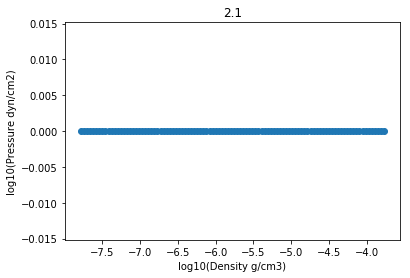

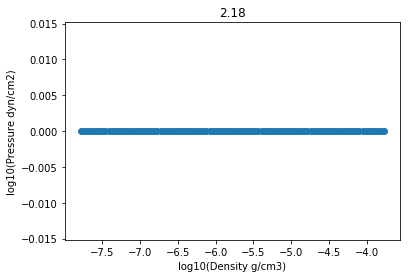

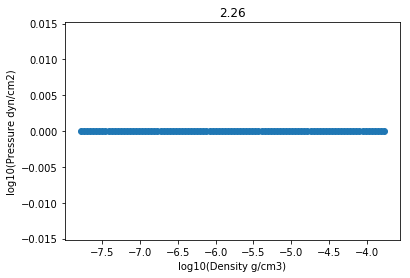

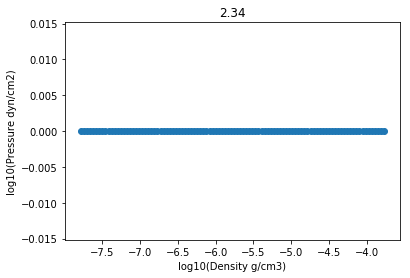

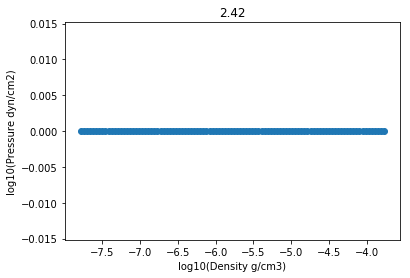

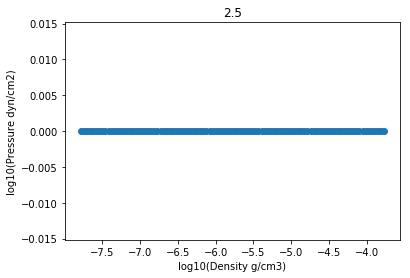

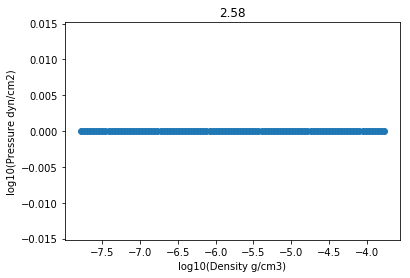

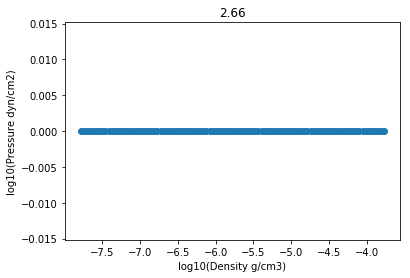

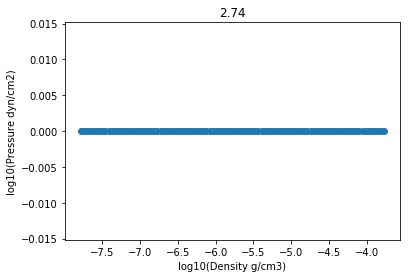

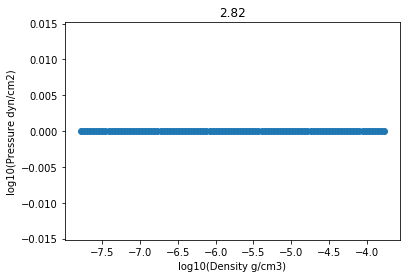

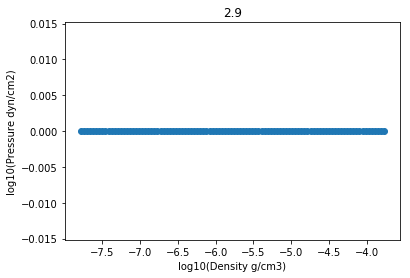

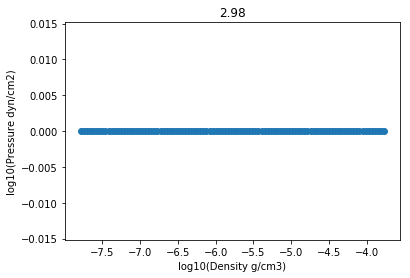

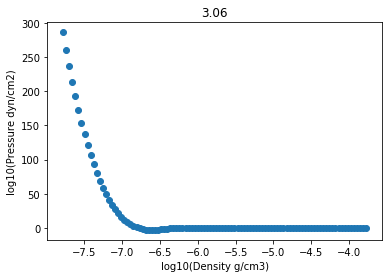

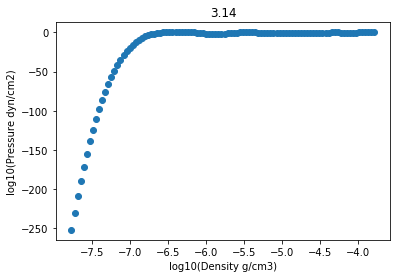

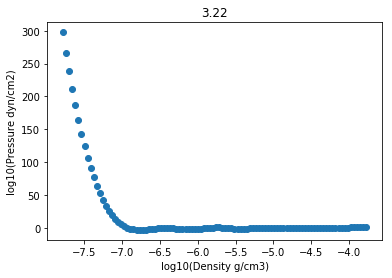

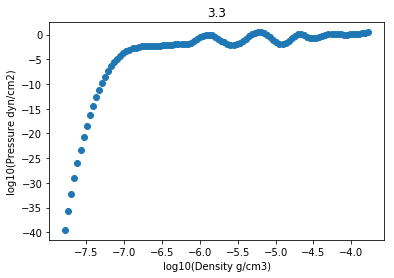

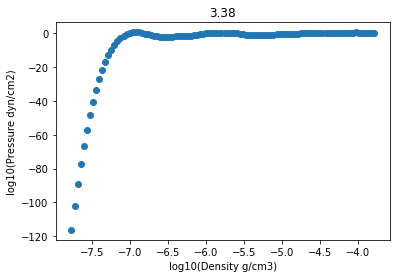

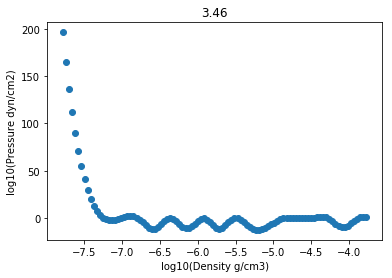

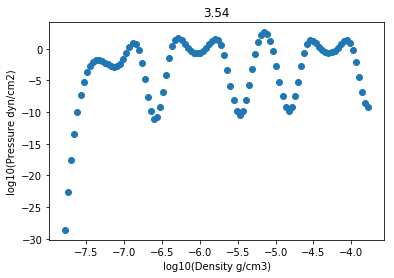

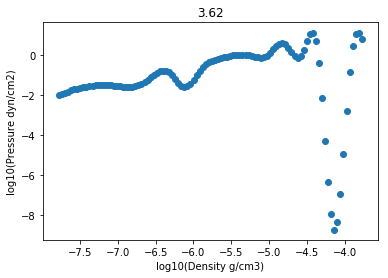

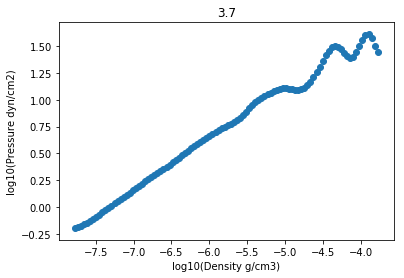

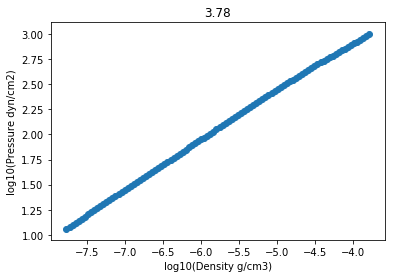

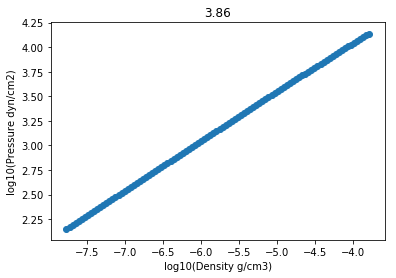

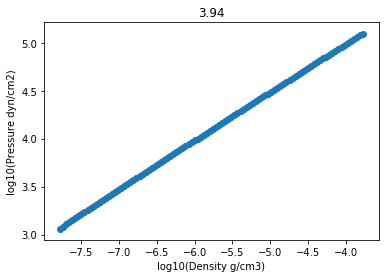

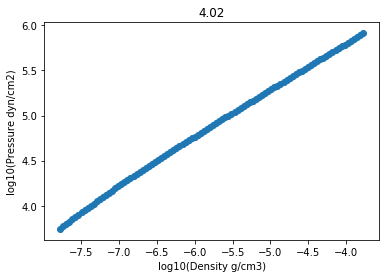

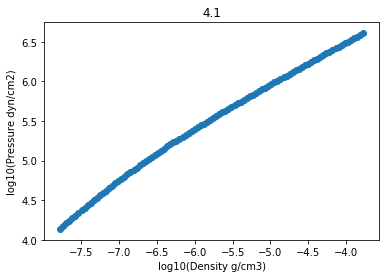

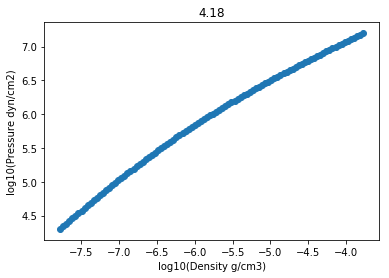

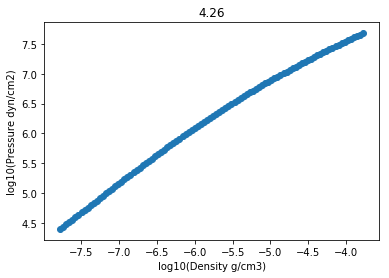

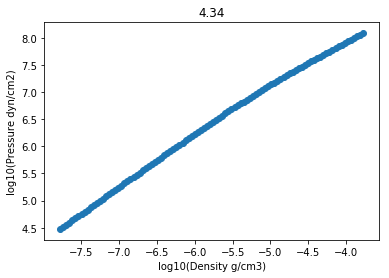

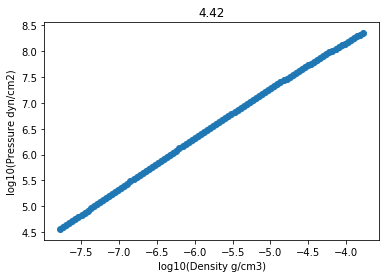

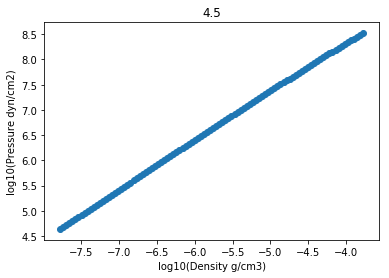

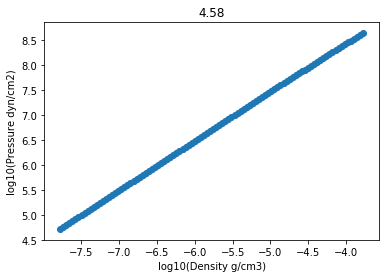

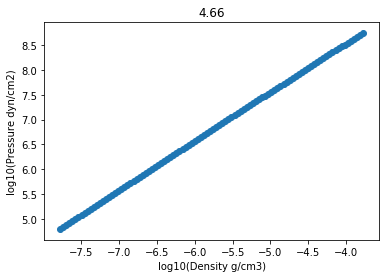

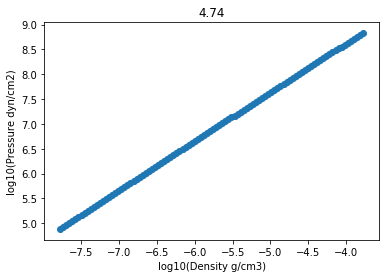

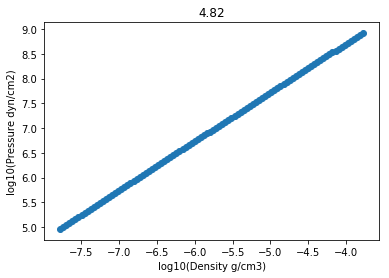

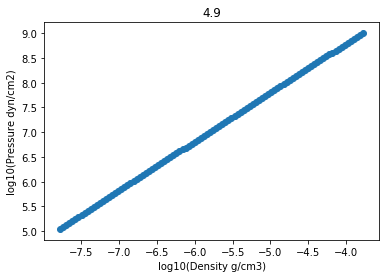

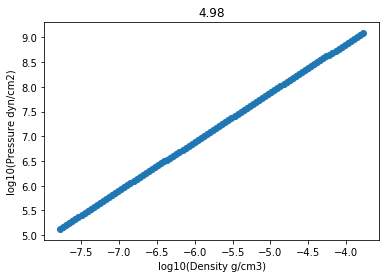

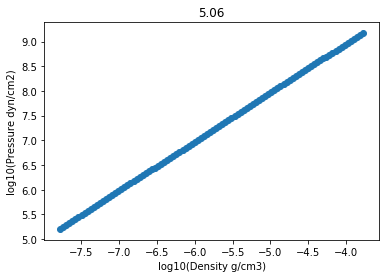

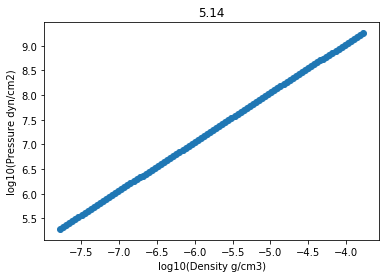

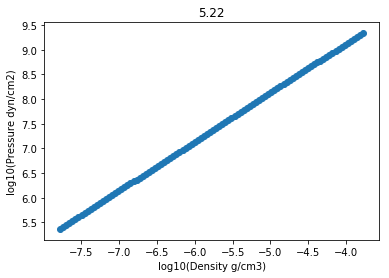

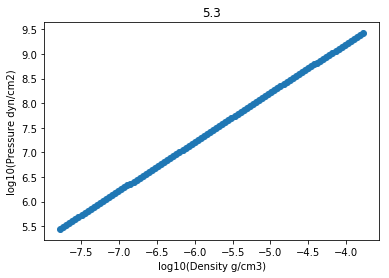

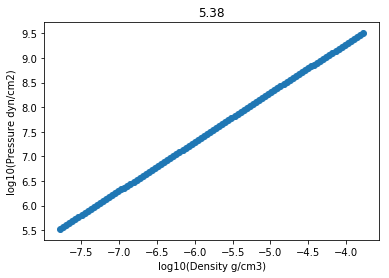

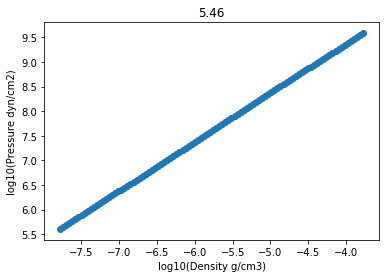

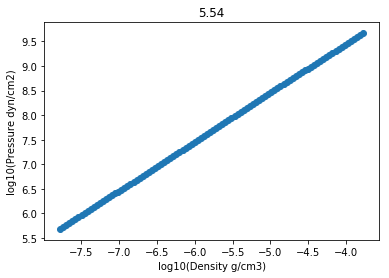

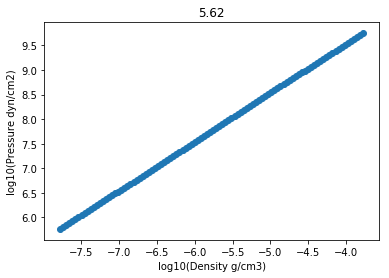

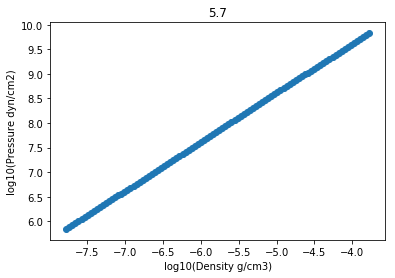

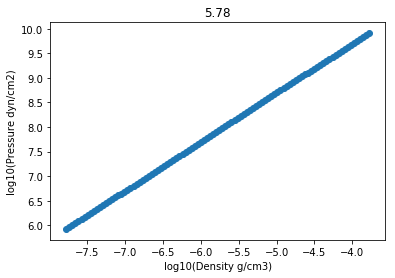

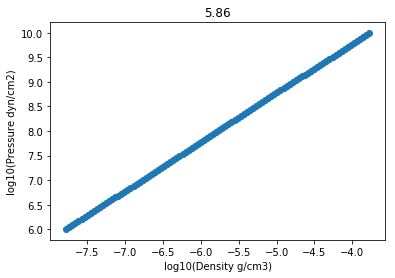

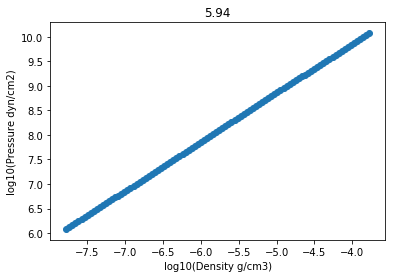

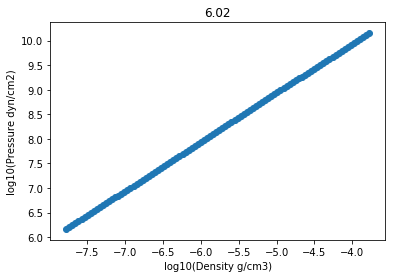

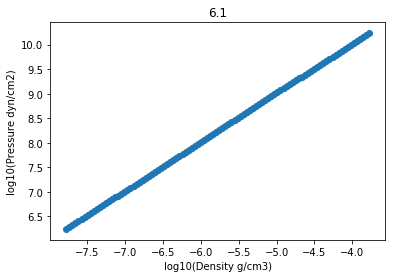

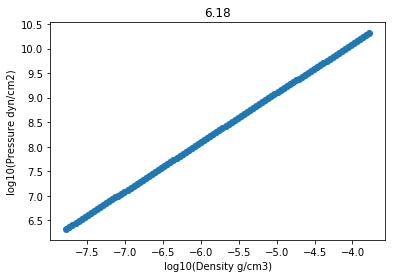

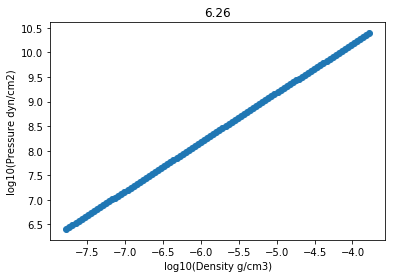

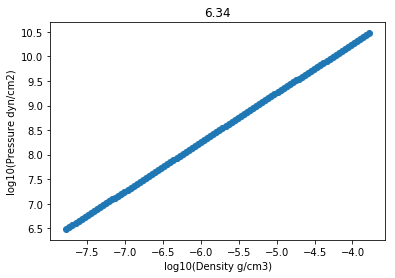

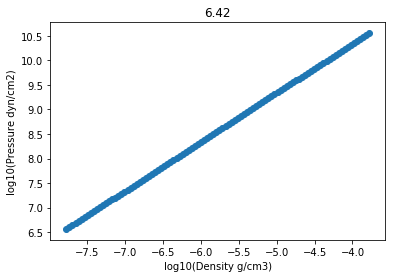

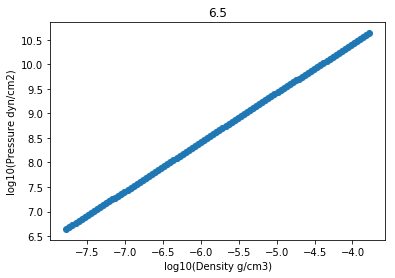

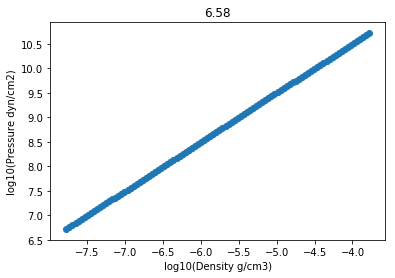

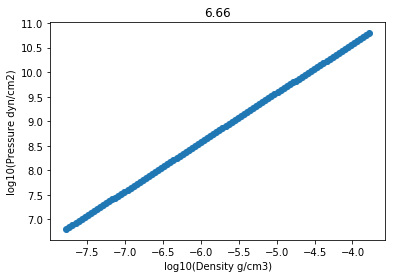

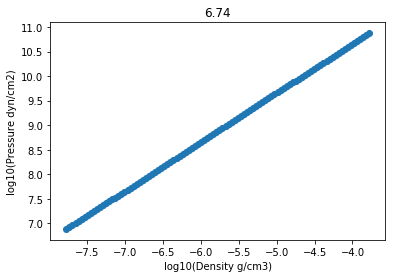

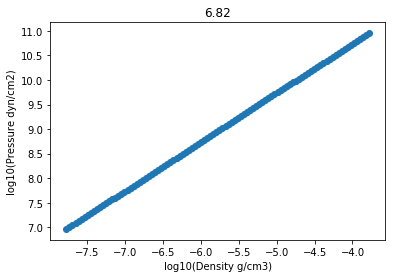

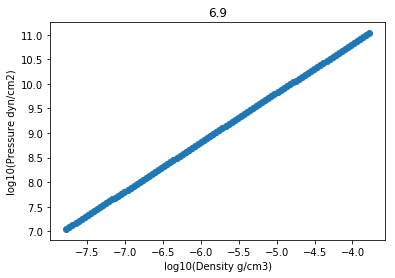

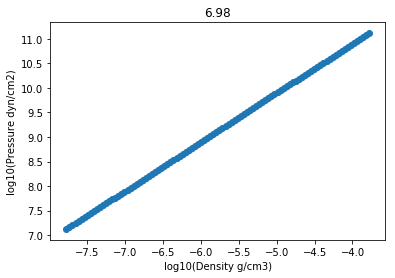

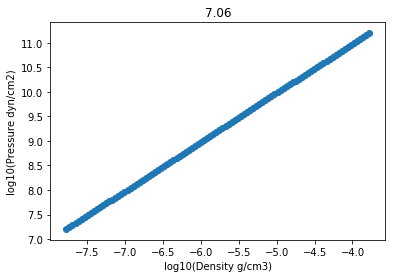

In [13]:
for temperature in eos_electrons_interp_rho['Temperature'].unique():
    sub_table = eos_electrons_interp_rho[eos_electrons_interp_rho['Temperature'] == temperature]
    x = sub_table['Density'] 
    y = sub_table['Pressure']
    plt.scatter(x, y)
    plt.title(str(temperature))
    plt.xlabel('log10(Density g/cm3)')
    plt.ylabel('log10(Pressure dyn/cm2)')
    plt.show()

In [14]:
#Interpolation for density T-rho table (ions)
eos_ions.dropna(inplace = True) #drop NaN values for interpolation
#print(eos_ions['Temperature'].unique()) 
sub_table_interp = pd.DataFrame()
eos_ions_interp_rho = pd.DataFrame()
interpolation_columns = ['Pressure', 'Internal Energy U', 'Concentration H2', 'Concentration H']
for temperature in eos_ions['Temperature'].unique(): #iterate over all temperature values
    sub_table = eos_ions[eos_ions['Temperature'] == temperature] #select sub-table at a given temperature
    for column_name in interpolation_columns:
        y = sub_table[column_name]
        x = sub_table['Mass density rho']
        func = interpolate.interp1d(x,y, kind='cubic', bounds_error=False, fill_value='extrapolate') #third order spline interpolation
        xnew = tabulated_densities
        sub_table_interp['Temperature'] = temperature
        sub_table_interp['Density'] = tabulated_densities
        sub_table_interp[column_name] = func(xnew)
    eos_ions_interp_rho = pd.concat([eos_ions_interp_rho, sub_table_interp])


In [15]:
print(eos_ions_interp_rho)
eos_ions_interp_rho.reset_index(inplace=True)

    Temperature   Density  Pressure  Internal Energy U  Concentration H2  Concentration H
0          2.10 -7.777284  1.938188          10.123616               1.0         0.000000
1          2.10 -7.736879  1.978588          10.123430               1.0         0.000000
2          2.10 -7.696475  2.018988          10.123250               1.0         0.000000
3          2.10 -7.656071  2.059389          10.123078               1.0         0.000000
4          2.10 -7.615667  2.099789          10.122911               1.0         0.000000
5          2.10 -7.575263  2.140190          10.122751               1.0         0.000000
6          2.10 -7.534859  2.180591          10.122597               1.0         0.000000
7          2.10 -7.494455  2.220992          10.122449               1.0         0.000000
8          2.10 -7.454051  2.261393          10.122307               1.0         0.000000
9          2.10 -7.413647  2.301795          10.122171               1.0         0.000000
10        

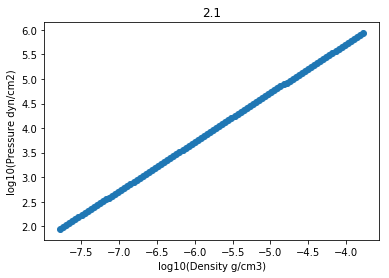

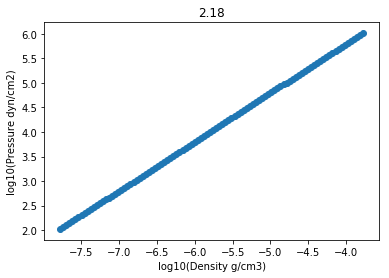

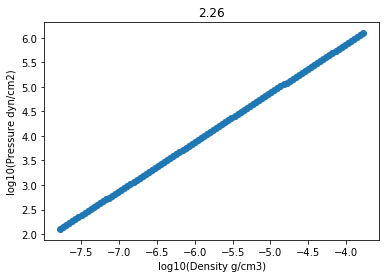

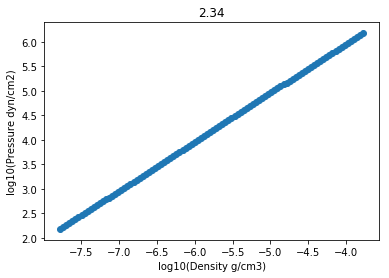

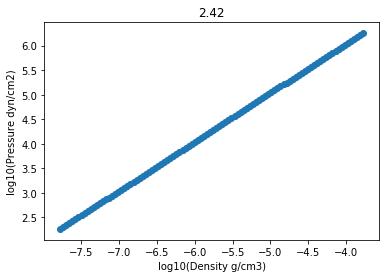

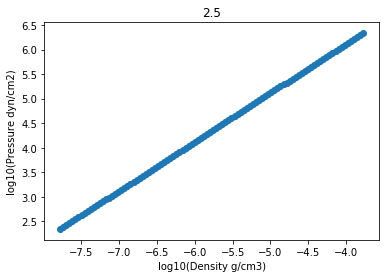

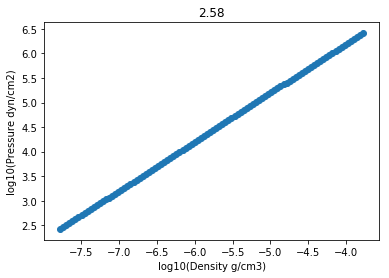

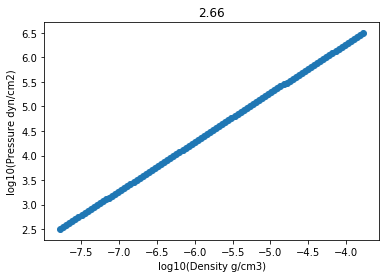

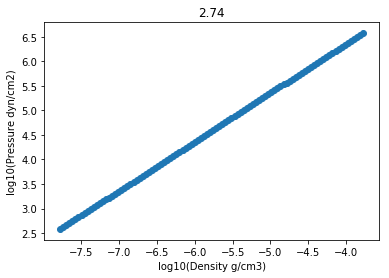

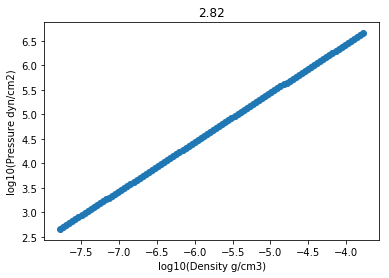

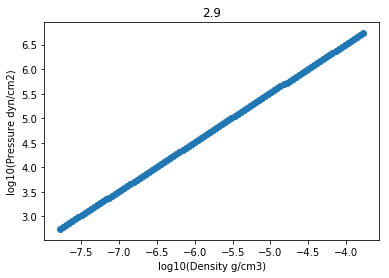

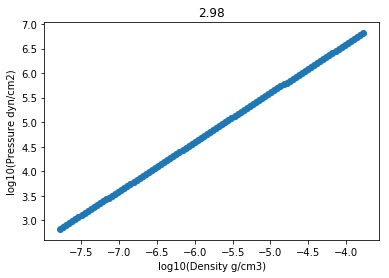

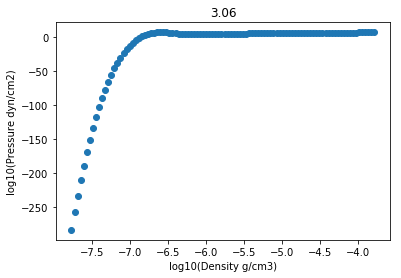

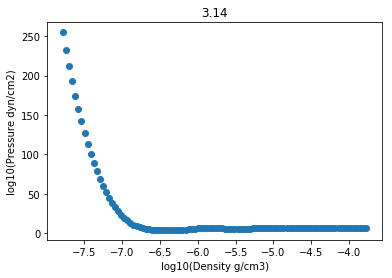

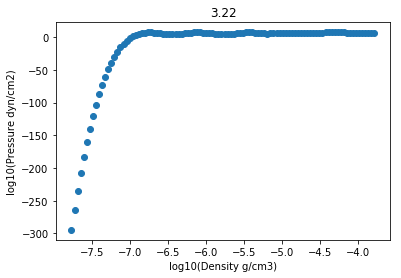

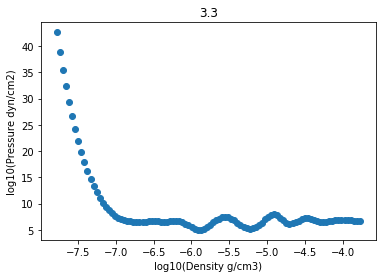

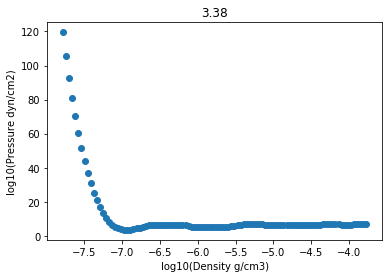

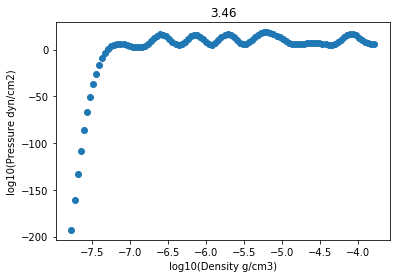

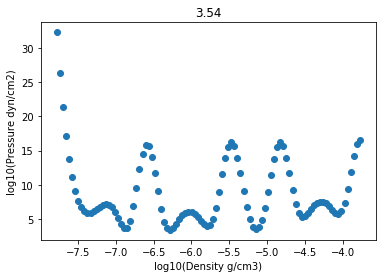

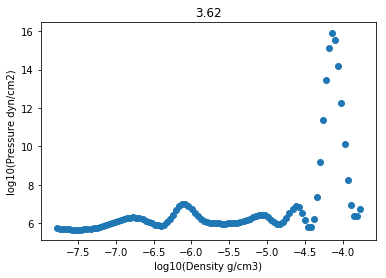

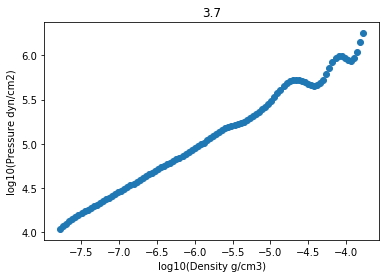

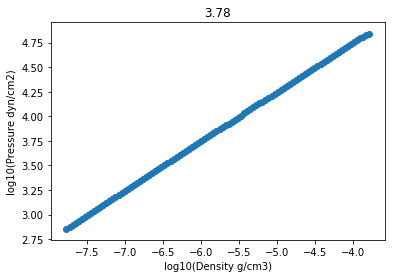

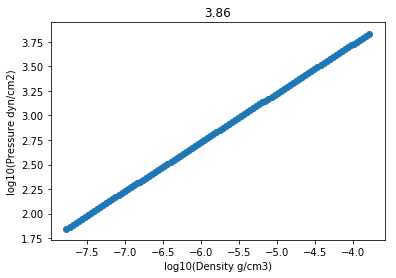

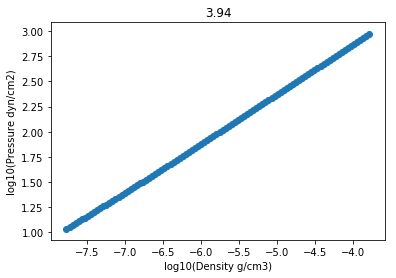

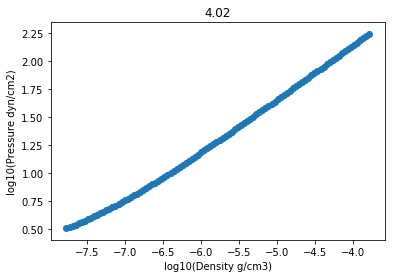

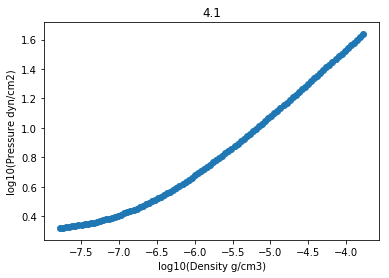

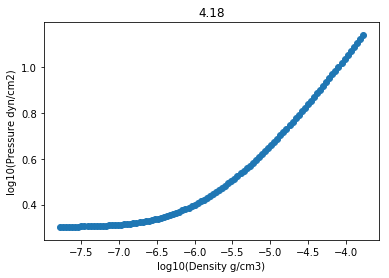

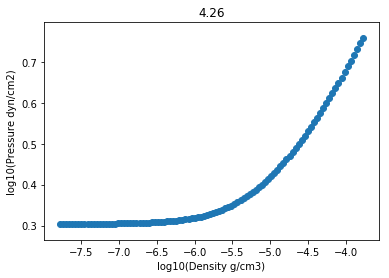

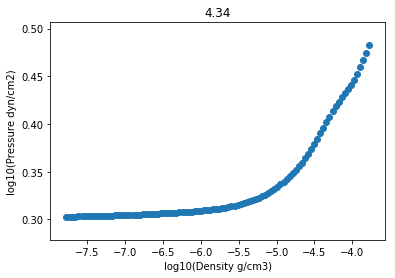

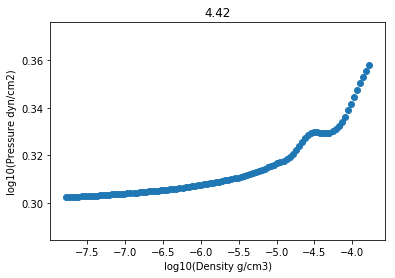

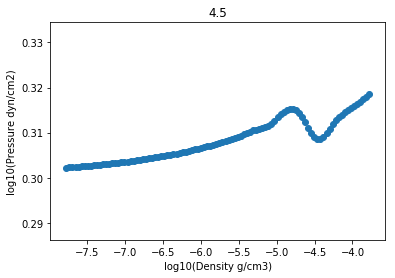

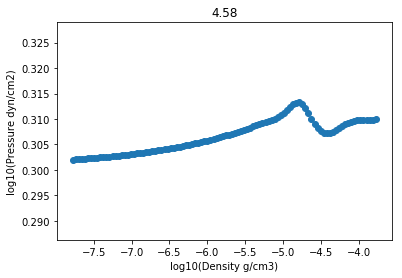

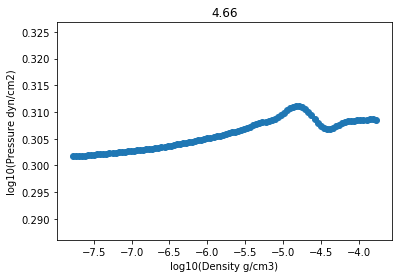

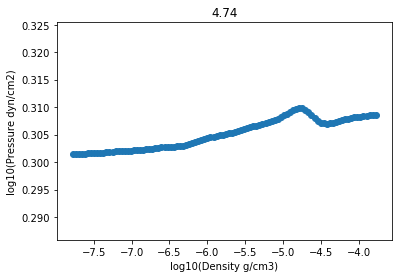

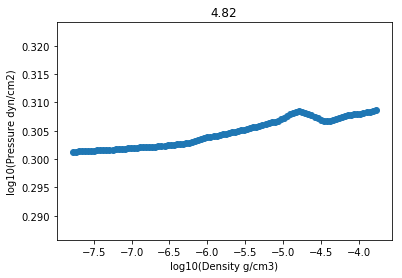

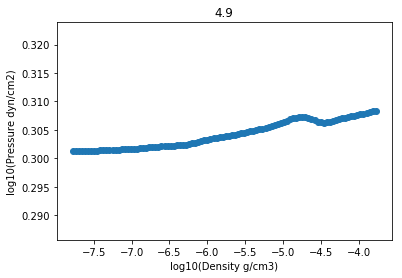

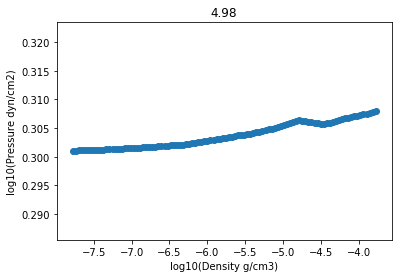

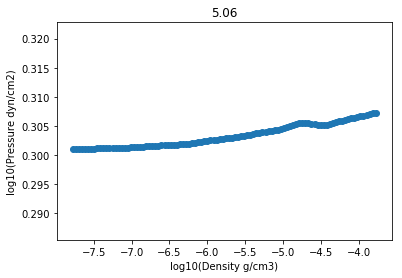

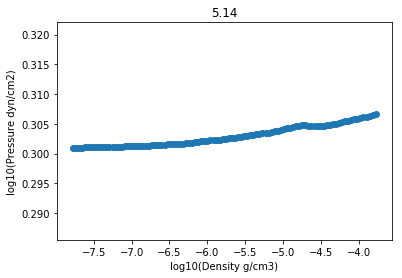

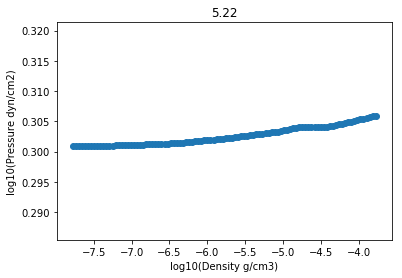

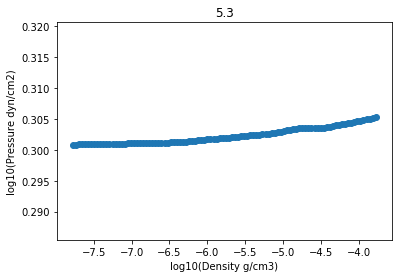

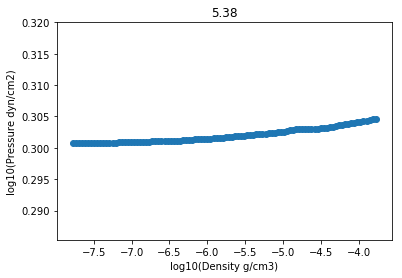

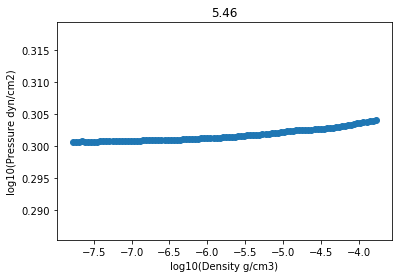

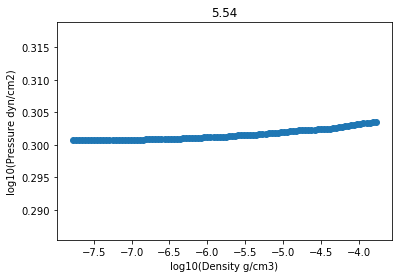

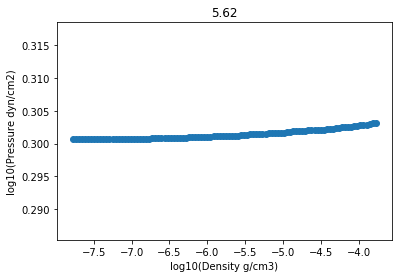

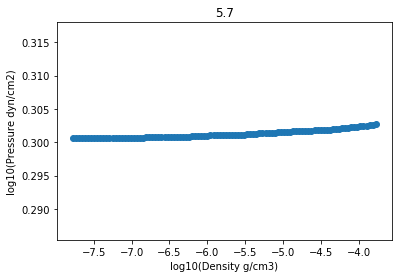

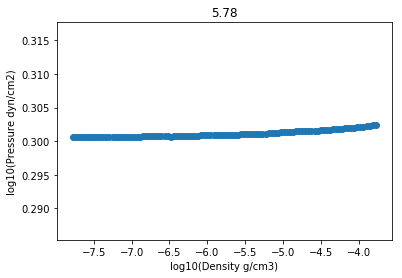

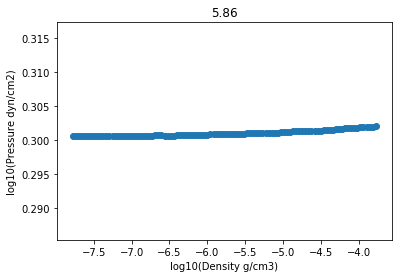

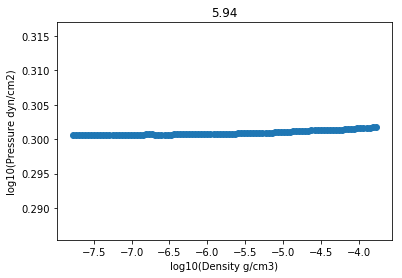

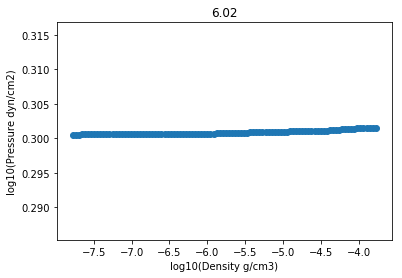

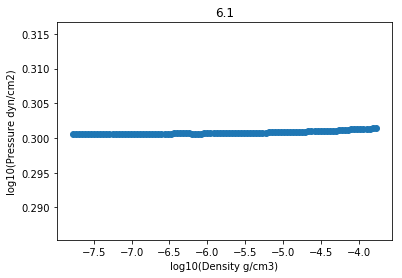

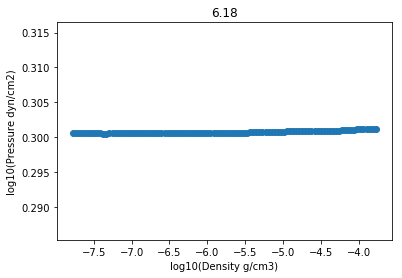

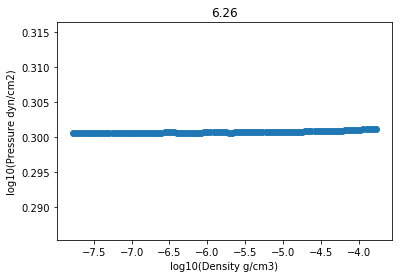

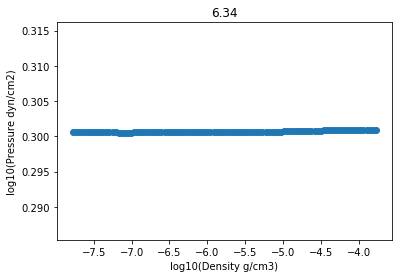

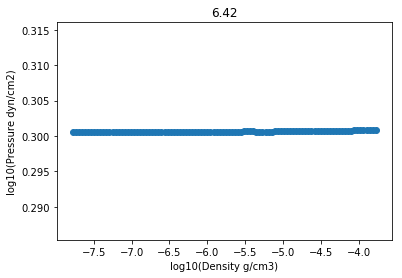

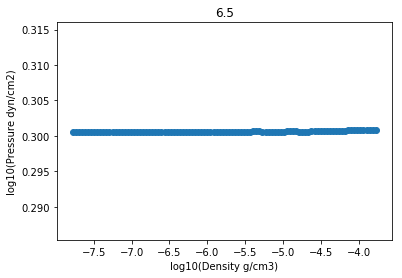

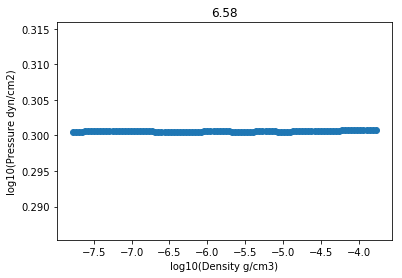

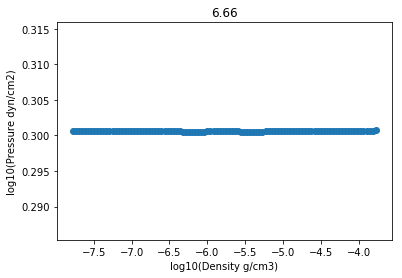

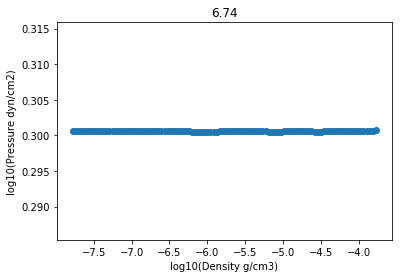

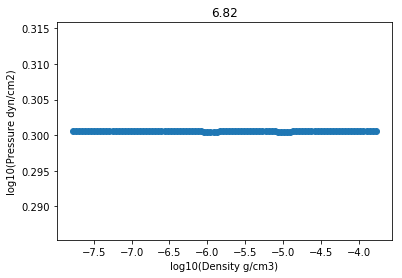

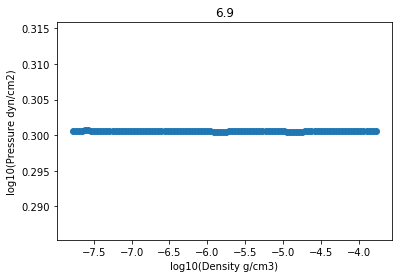

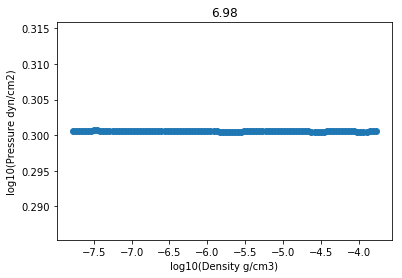

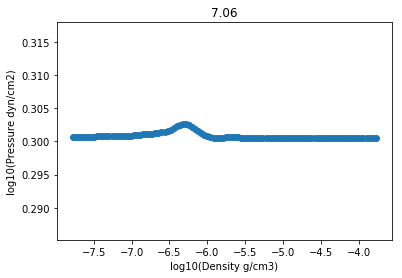

In [16]:
for temperature in eos_ions_interp_rho['Temperature'].unique():
    sub_table = eos_ions_interp_rho[eos_ions_interp_rho['Temperature'] == temperature]
    x = sub_table['Density'] 
    y = sub_table['Pressure']
    plt.scatter(x, y)
    plt.title(str(temperature))
    plt.xlabel('log10(Density g/cm3)')
    plt.ylabel('log10(Pressure dyn/cm2)')
    plt.show()

In [17]:
#Interpolation for temperature rho-T table (electrons)
print(eos_electrons_interp_rho['Density'].unique()) 
print(len(eos_electrons_interp_rho['Density'].unique()))
sub_table_interp = pd.DataFrame()
eos_electrons_interp_T = pd.DataFrame()
interpolation_columns = ['Pressure', 'Internal Energy U', 'Concentration H2', 'Concentration H']
for density in eos_electrons_interp_rho['Density'].unique(): #iterate over all unique density values
    sub_table = eos_electrons_interp_rho[eos_electrons_interp_rho['Density'] == density] #select sub-table at a given density
    for column_name in interpolation_columns:
        y = sub_table[column_name]
        x = sub_table['Temperature']
        func = interpolate.interp1d(x,y, kind='cubic', bounds_error=False, fill_value='extrapolate') #third order spline interpolation
        xnew = tabulated_temperatures_e
        sub_table_interp['Density'] = density
        sub_table_interp['Temperature'] = tabulated_temperatures_e
        sub_table_interp[column_name] = func(xnew)
    eos_electrons_interp_T = pd.concat([eos_electrons_interp_T, sub_table_interp])

[-7.77728353 -7.73687949 -7.69647545 -7.65607141 -7.61566737 -7.57526333
 -7.53485929 -7.49445525 -7.45405121 -7.41364717 -7.37324312 -7.33283908
 -7.29243504 -7.252031   -7.21162696 -7.17122292 -7.13081888 -7.09041484
 -7.0500108  -7.00960676 -6.96920272 -6.92879868 -6.88839464 -6.8479906
 -6.80758656 -6.76718252 -6.72677848 -6.68637444 -6.6459704  -6.60556636
 -6.56516232 -6.52475828 -6.48435424 -6.4439502  -6.40354616 -6.36314211
 -6.32273807 -6.28233403 -6.24192999 -6.20152595 -6.16112191 -6.12071787
 -6.08031383 -6.03990979 -5.99950575 -5.95910171 -5.91869767 -5.87829363
 -5.83788959 -5.79748555 -5.75708151 -5.71667747 -5.67627343 -5.63586939
 -5.59546535 -5.55506131 -5.51465727 -5.47425323 -5.43384919 -5.39344515
 -5.3530411  -5.31263706 -5.27223302 -5.23182898 -5.19142494 -5.1510209
 -5.11061686 -5.07021282 -5.02980878 -4.98940474 -4.9490007  -4.90859666
 -4.86819262 -4.82778858 -4.78738454 -4.7469805  -4.70657646 -4.66617242
 -4.62576838 -4.58536434 -4.5449603  -4.50455626 -4.4

In [18]:
print(eos_electrons_interp_T)

     Density  Temperature   Pressure  Internal Energy U  Concentration H2  Concentration H
0  -7.777284     0.000000  23.259197         -50.261863      1.000003e+00     6.796313e-06
1  -7.777284     0.061259  21.351313         -46.139029      1.000003e+00     6.238831e-06
2  -7.777284     0.122518  19.550673         -42.247945      1.000003e+00     5.712686e-06
3  -7.777284     0.183777  17.854179         -38.581912      1.000003e+00     5.216972e-06
4  -7.777284     0.245035  16.258727         -35.134228      1.000002e+00     4.750783e-06
5  -7.777284     0.306294  14.761219         -31.898194      1.000002e+00     4.313213e-06
6  -7.777284     0.367553  13.358552         -28.867107      1.000002e+00     3.903355e-06
7  -7.777284     0.428812  12.047627         -26.034269      1.000002e+00     3.520304e-06
8  -7.777284     0.490071  10.825343         -23.392978      1.000002e+00     3.163154e-06
9  -7.777284     0.551330   9.688598         -20.936534      1.000001e+00     2.830998e-06

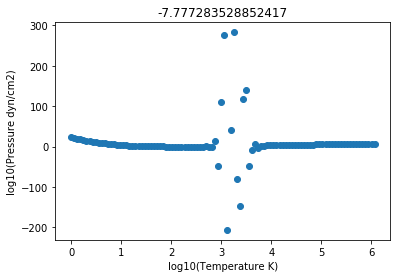

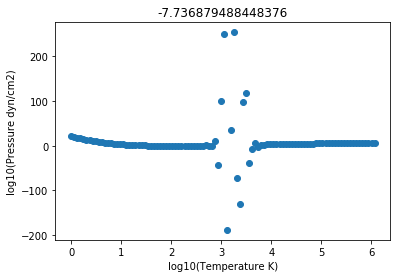

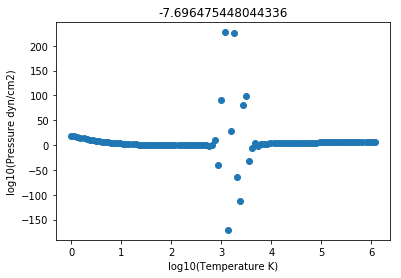

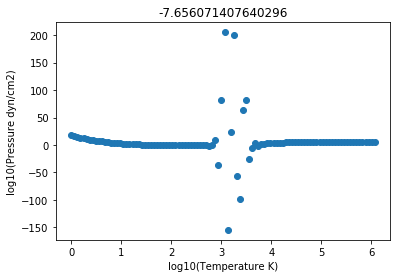

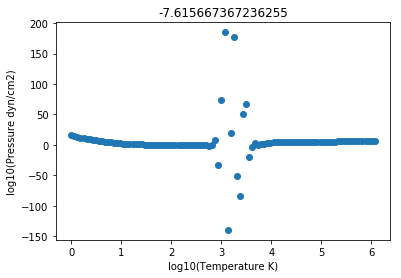

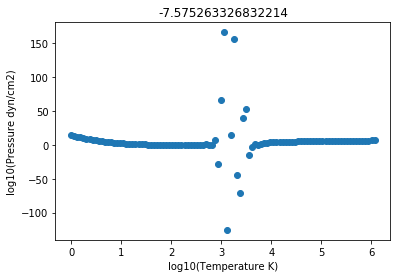

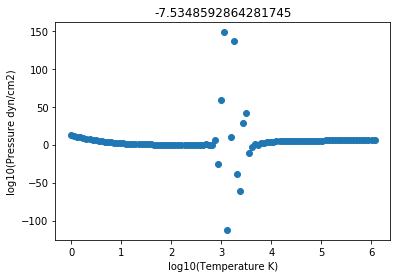

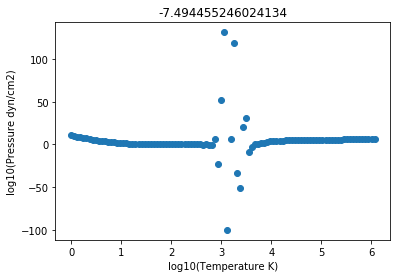

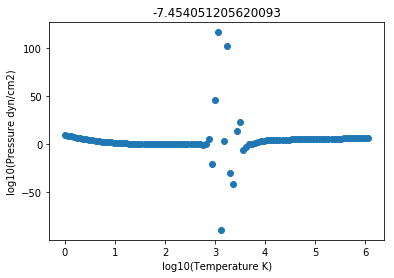

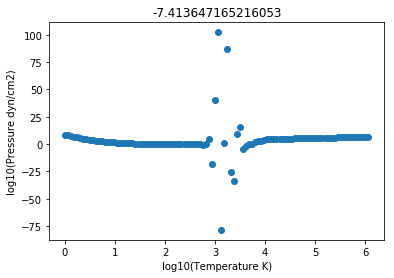

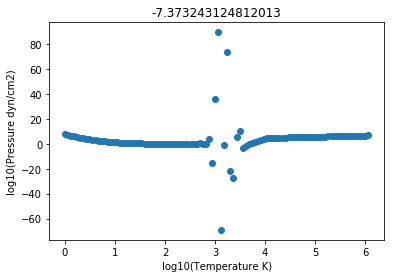

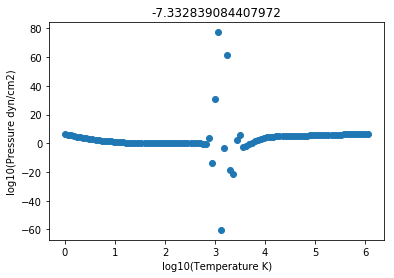

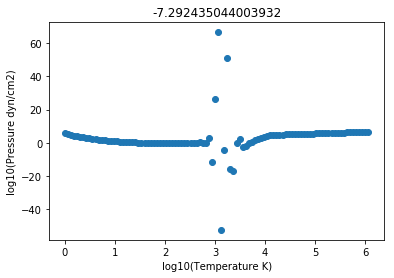

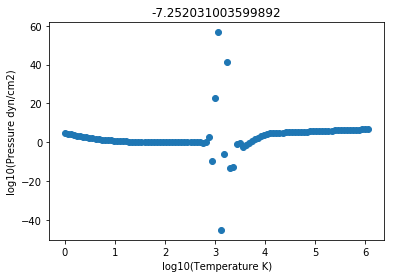

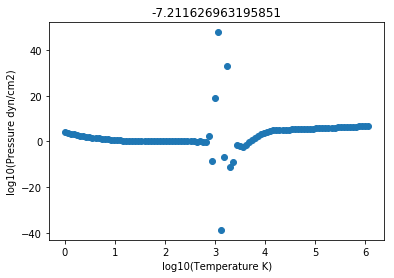

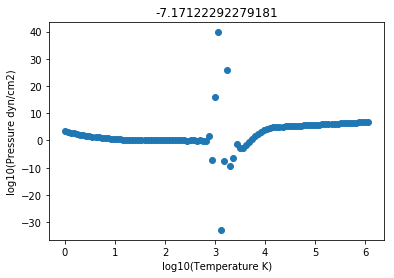

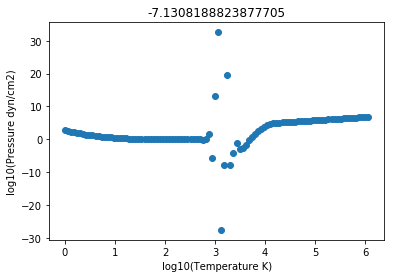

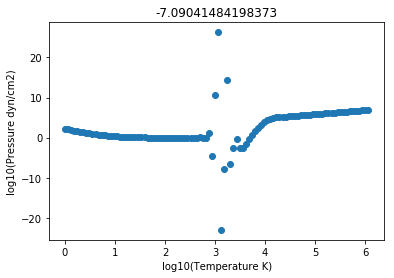

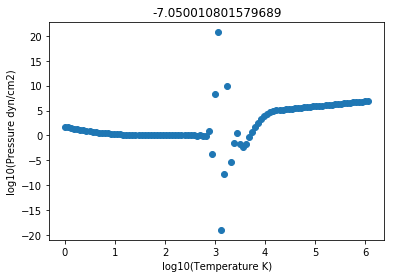

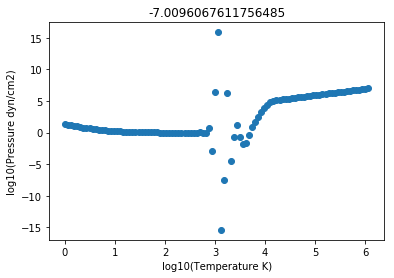

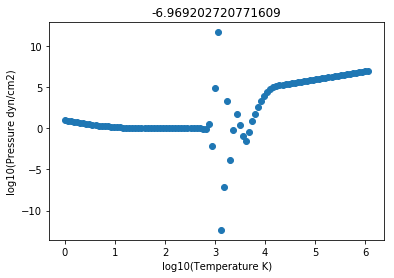

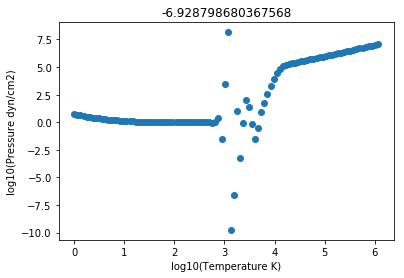

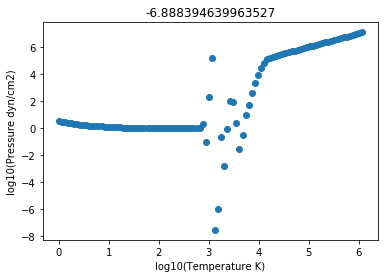

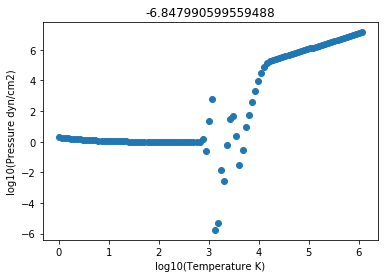

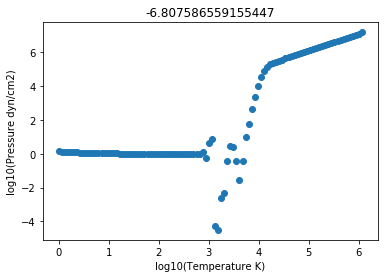

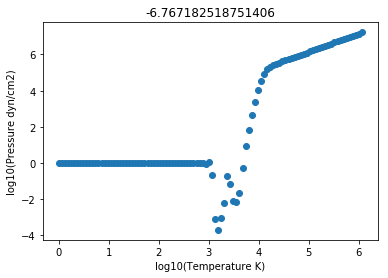

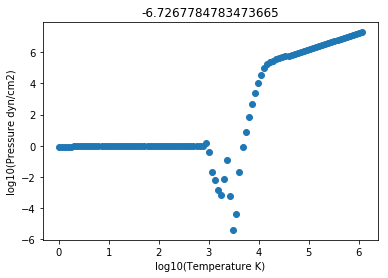

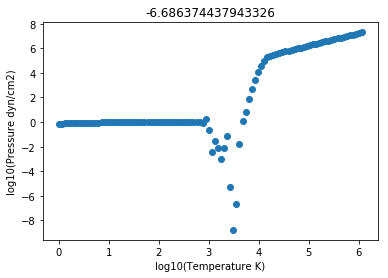

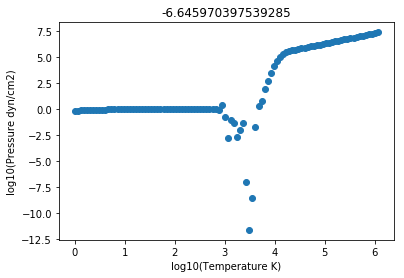

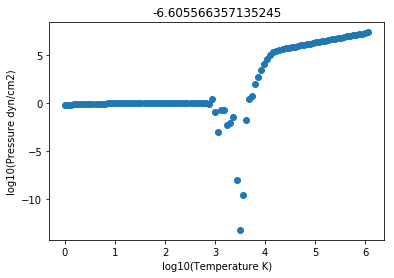

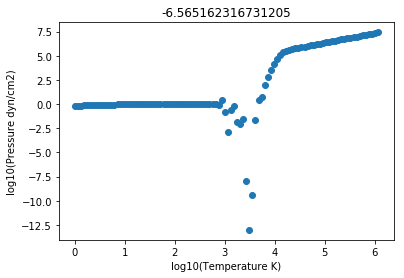

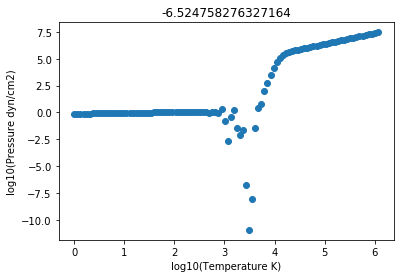

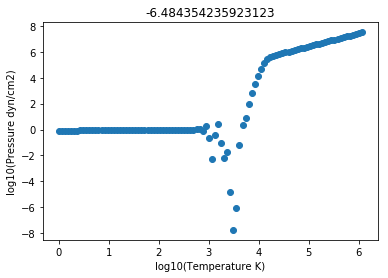

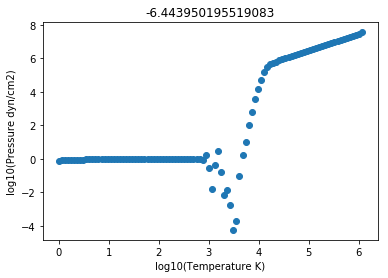

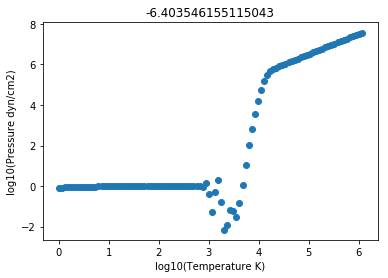

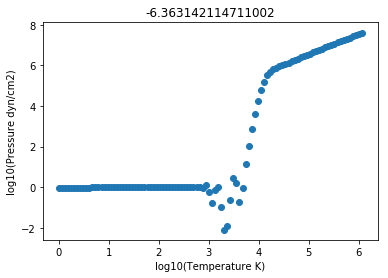

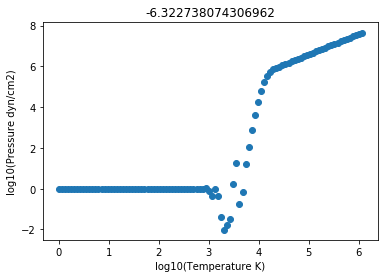

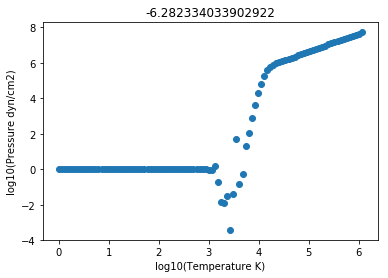

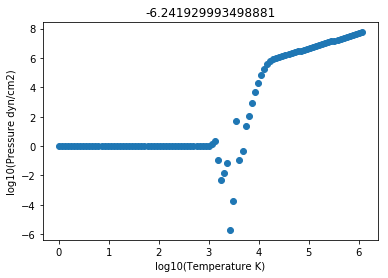

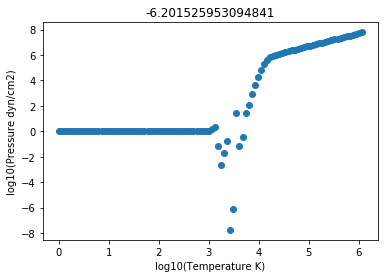

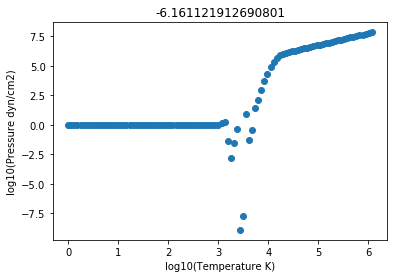

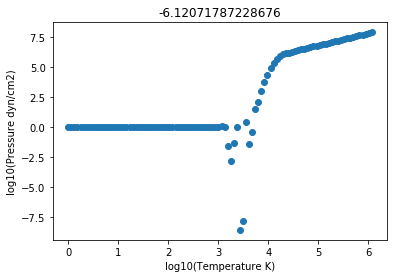

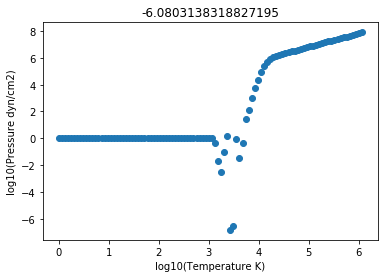

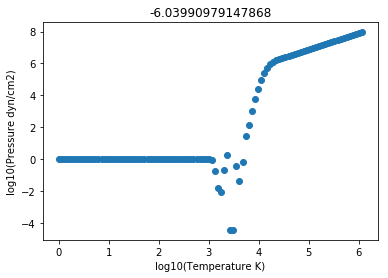

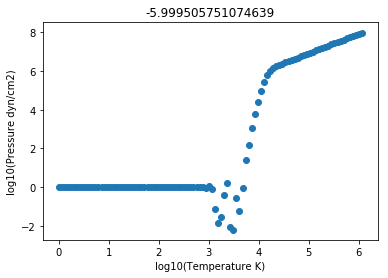

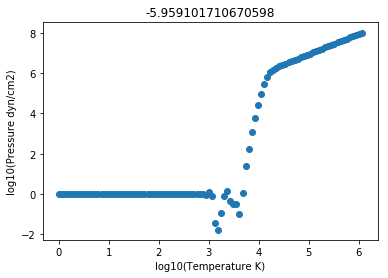

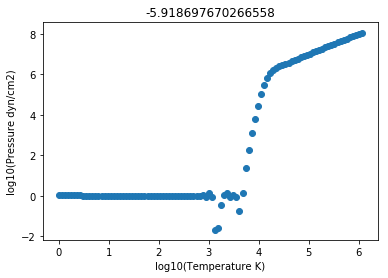

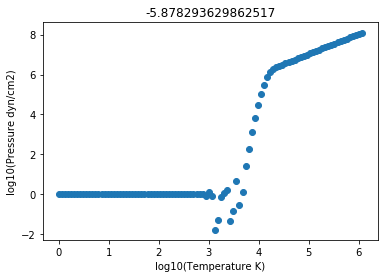

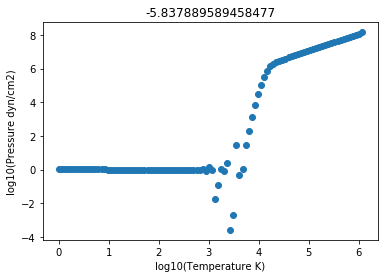

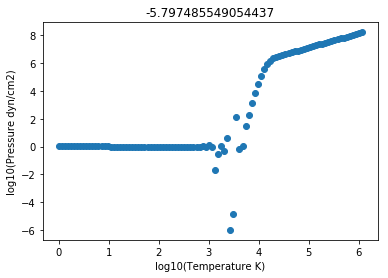

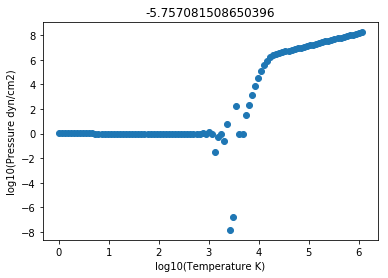

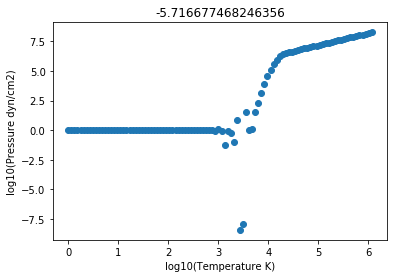

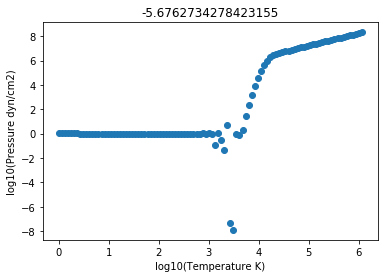

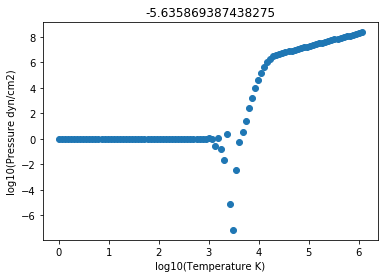

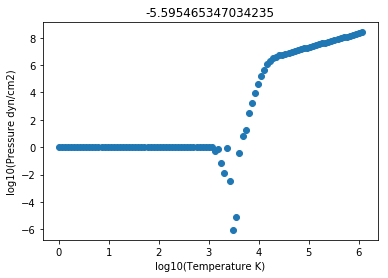

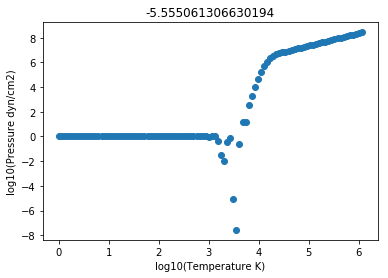

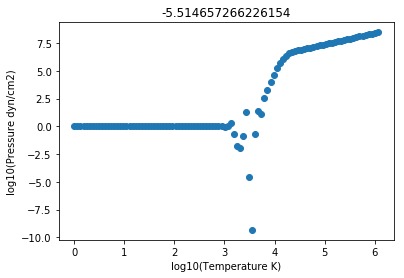

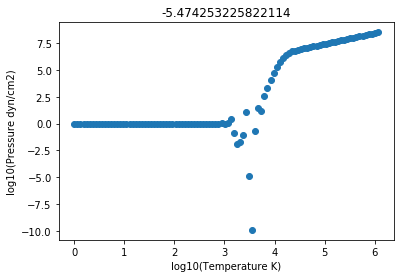

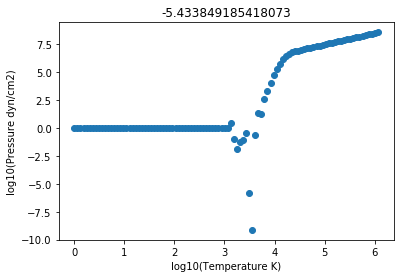

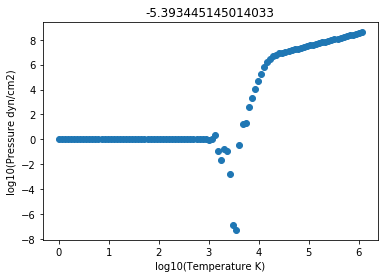

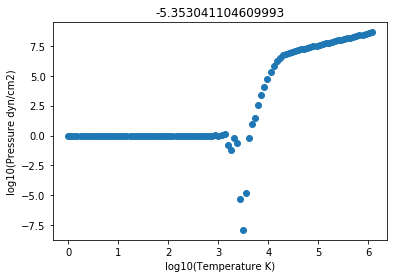

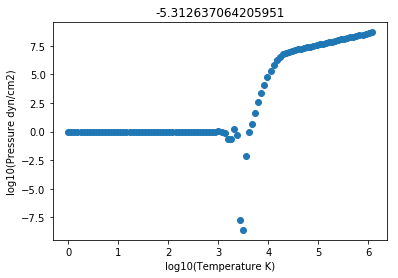

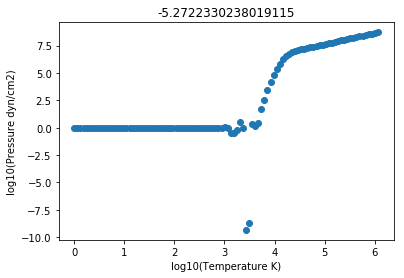

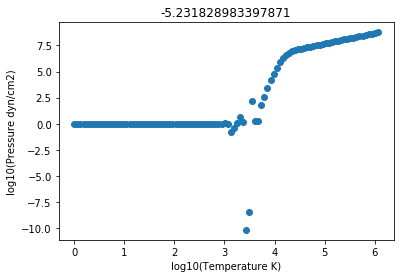

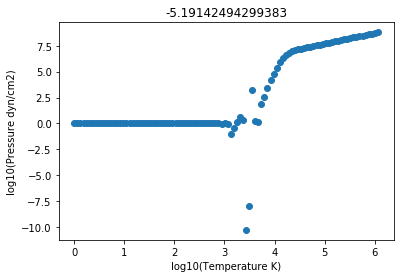

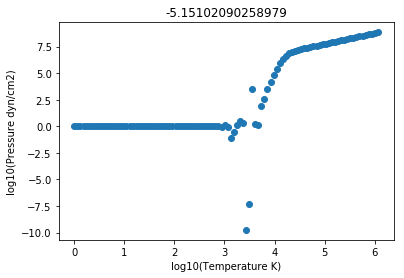

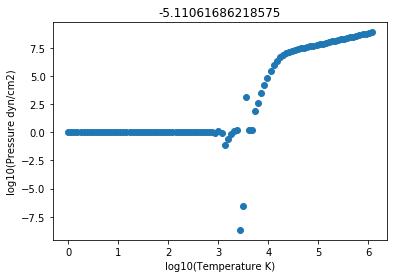

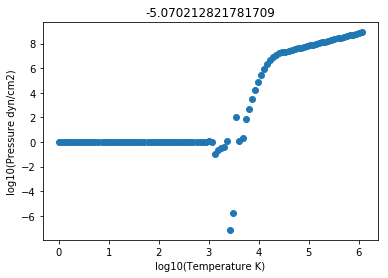

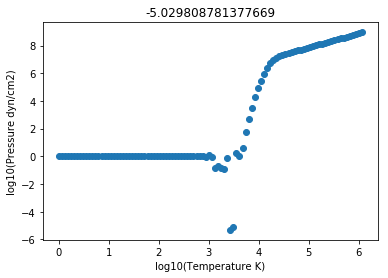

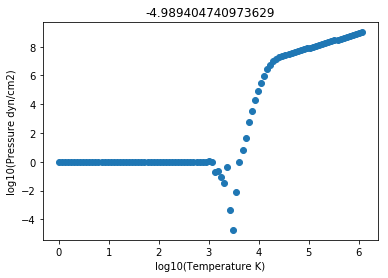

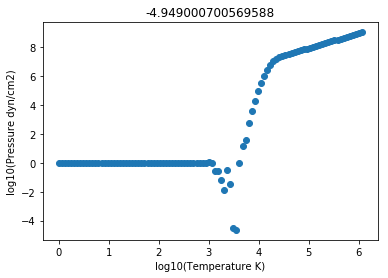

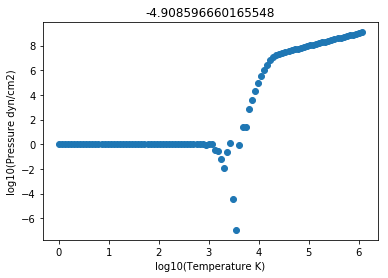

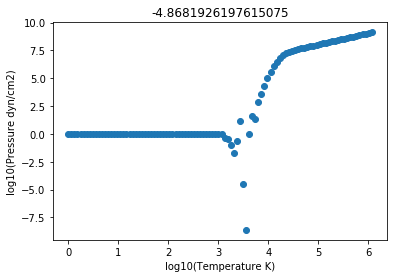

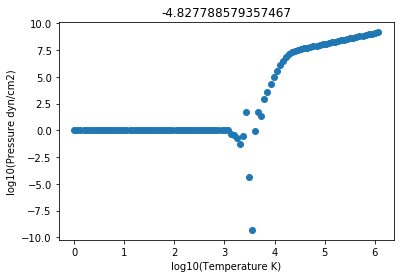

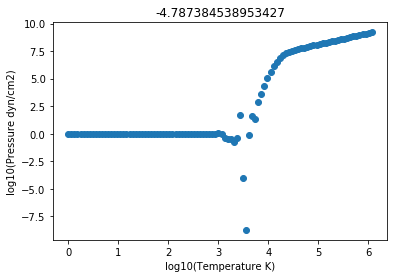

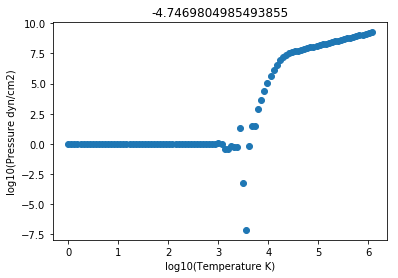

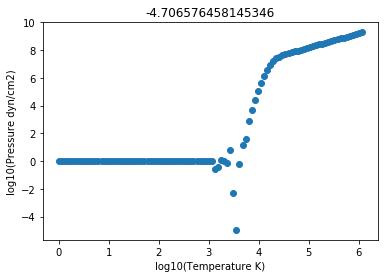

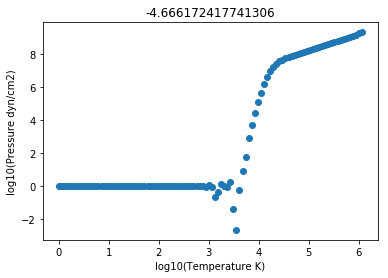

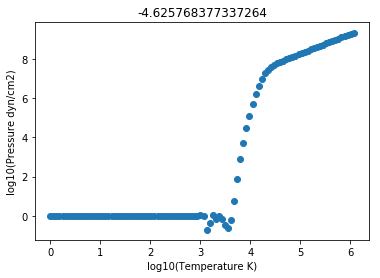

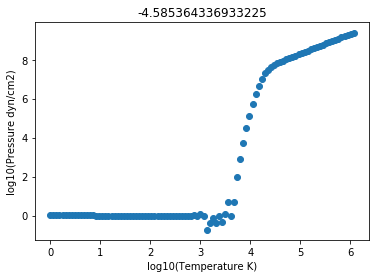

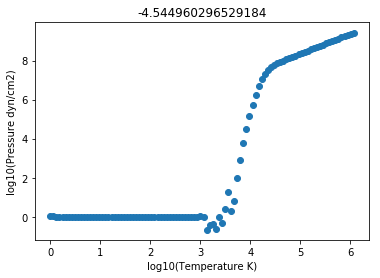

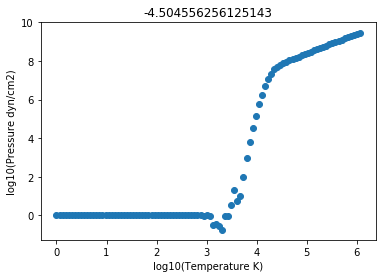

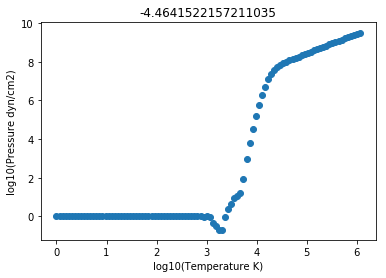

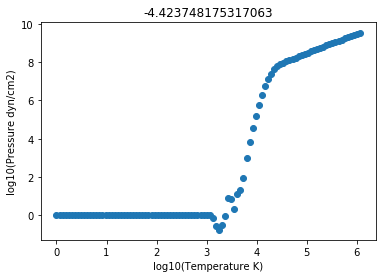

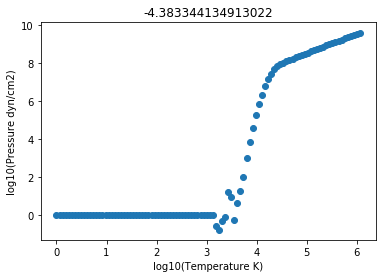

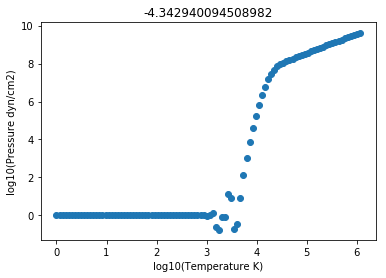

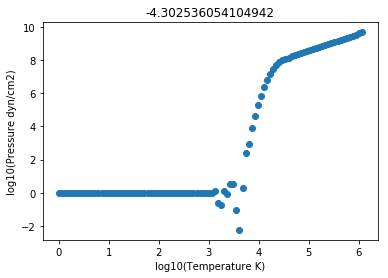

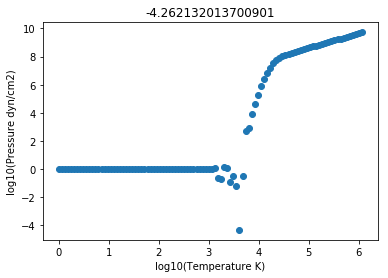

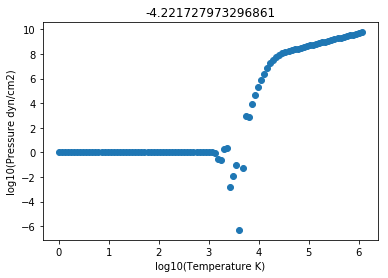

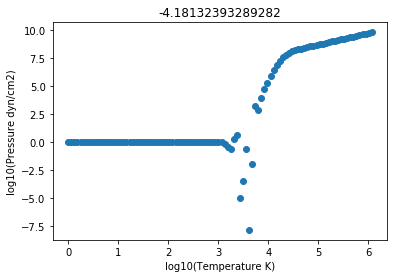

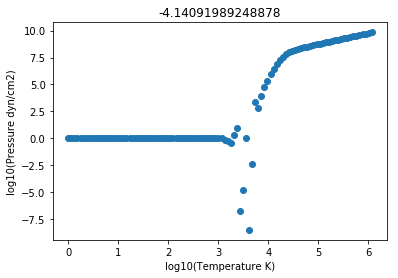

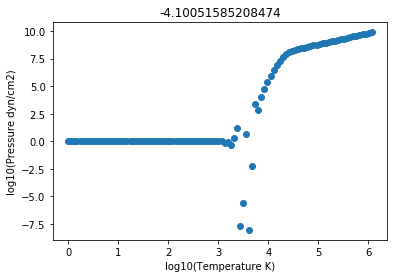

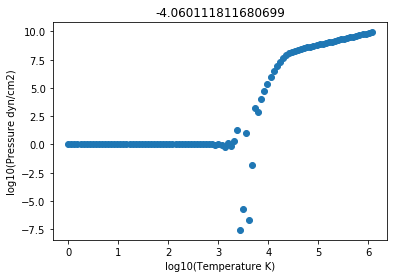

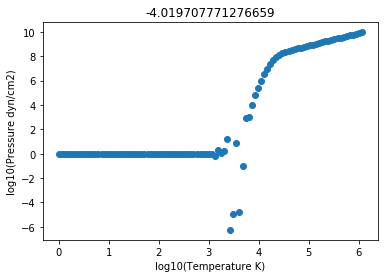

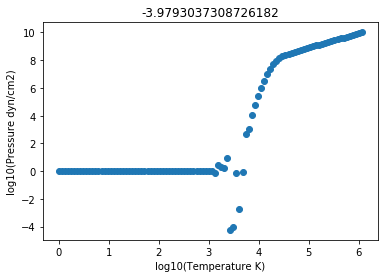

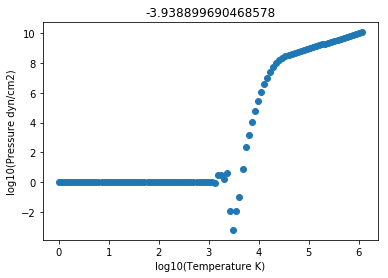

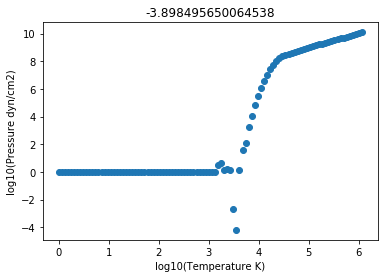

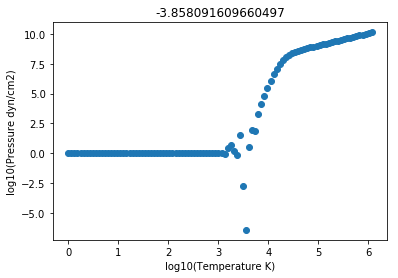

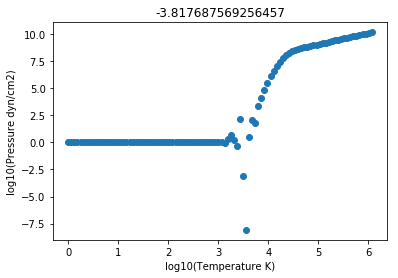

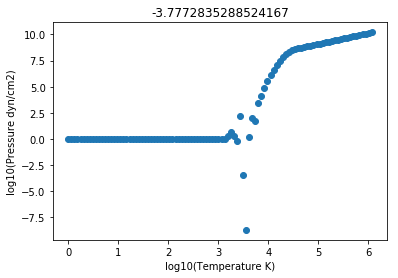

In [19]:
import matplotlib.pyplot as plt
for density in eos_electrons_interp_T['Density'].unique():
    sub_table = eos_electrons_interp_T[eos_electrons_interp_T['Density'] == density]
    x = sub_table['Temperature'] 
    y = sub_table['Pressure']
    plt.scatter(x, y)
    plt.title(str(density))
    plt.xlabel('log10(Temperature K)')
    plt.ylabel('log10(Pressure dyn/cm2)')
    plt.show()